# Automatic Detection of Hot-Rolled Steel Strips Surface Defects using Convolutional Neural Network
#### This project aims to automatically detect surface defects in Hot-Rolled Steel Strips such as rolled-in scale, patches, crazing, pitted surface, inclusion and scratches (as depicted in the image below). A Convolutional Neural Network Model is developed and trained on the NEU Metal Surface Defects Database which contains 1800 grayscale images with 300 samples of each of the six different kinds of surface defects.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 20 kB/s 
     |████████████████████████████████| 1.7 MB 67.3 MB/s 
     |████████████████████████████████| 6.0 MB 71.4 MB/s 
     |████████████████████████████████| 439 kB 76.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

In [4]:
!nvidia-smi


Thu Dec 15 10:22:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    31W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Importing Relevant Libraries

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras_preprocessing.image import ImageDataGenerator
from sklearn.datasets import load_files
from keras.utils import np_utils
from keras_preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers import BatchNormalization

## 2. Importing the NEU Metal Surface Defect Dataset

In [6]:
train_dir = '/content/drive/MyDrive/Datasets/NEU Metal Surface Defects Data/train'
val_dir = '/content/drive/MyDrive/Datasets/NEU Metal Surface Defects Data/valid'
test_dir='/content/drive/MyDrive/Datasets/NEU Metal Surface Defects Data/test'
print("Path: ",os.listdir("/content/drive/MyDrive/Datasets/NEU Metal Surface Defects Data"))
print("Train: ",os.listdir("/content/drive/MyDrive/Datasets/NEU Metal Surface Defects Data/train"))
print("Test: ",os.listdir("/content/drive/MyDrive/Datasets/NEU Metal Surface Defects Data/test"))
print("Validation: ",os.listdir("/content/drive/MyDrive/Datasets/NEU Metal Surface Defects Data/valid"))

Path:  ['valid', 'train', 'test']
Train:  ['Inclusion', 'Patches', 'Rolled', 'Pitted', 'Scratches', 'Crazing']
Test:  ['Patches', 'Scratches', 'Pitted', 'Inclusion', 'Crazing', 'Rolled']
Validation:  ['Patches', 'Scratches', 'Crazing', 'Pitted', 'Inclusion', 'Rolled']


#### For each Class, the Training Data includes 276 Images, Validation & Test sets have 12 images each.

In [7]:
print("Inclusion Defect")
print("Training Images:",len(os.listdir(train_dir+'/'+'Inclusion')))
print("Testing Images:",len(os.listdir(test_dir+'/'+'Inclusion')))
print("Validation Images:",len(os.listdir(val_dir+'/'+'Inclusion')))

Inclusion Defect
Training Images: 210
Testing Images: 45
Validation Images: 45


## 3. Data Pre-processing

In [8]:
# Rescaling all Images by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training images are put in batches of 10
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Validation images are put in batches of 10
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


#### Setting upper Limit of Max 98% training accuracy

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True 

## 4. Defining the CNN Architecture

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from glob import glob
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
vgg16 = VGG16(input_shape=[200,200] + [3], weights='imagenet', include_top=False)
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False
 # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Datasets/NEU Metal Surface Defects Data//train/*')
# our layers - you can add more if you want
x = Flatten()(vgg16.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

# view the structure of the model
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

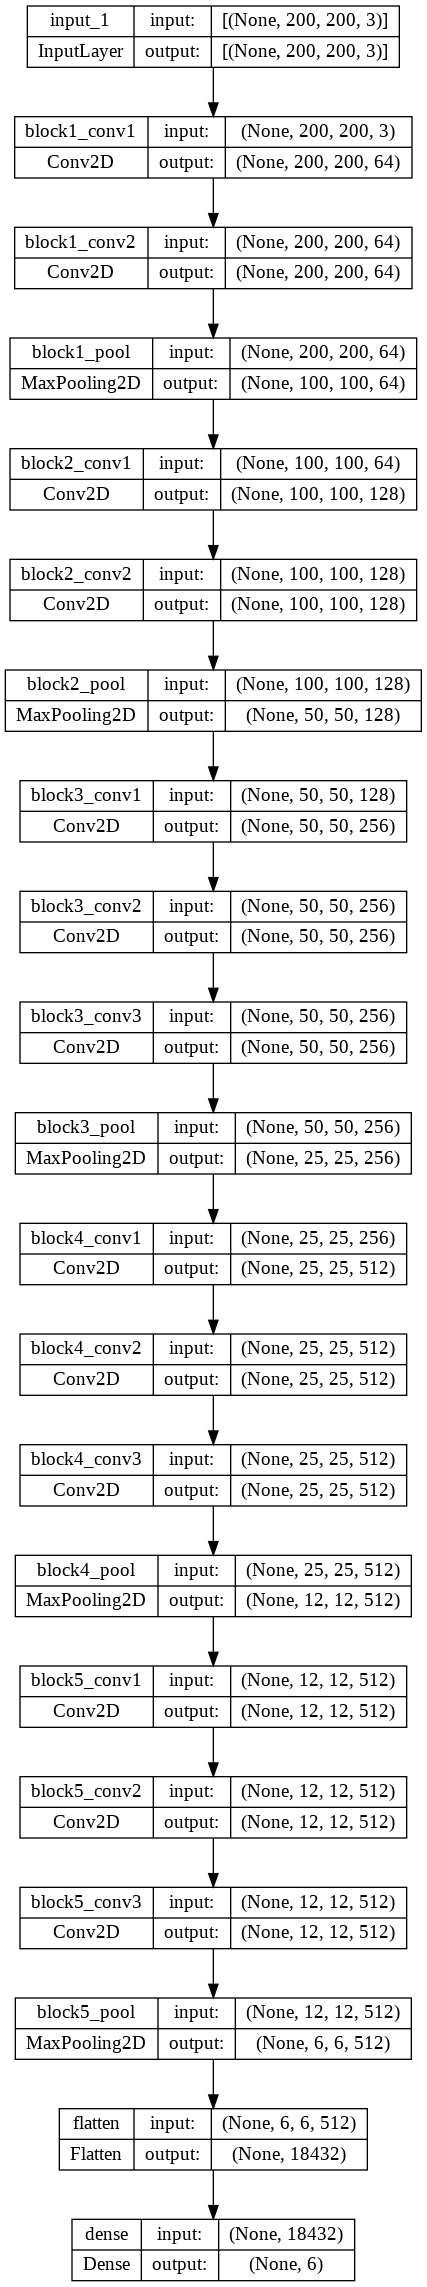

In [12]:
tf.keras.utils.plot_model(
    model,
    to_file='cnn_architecture.png',
    show_shapes=True)

## 5. Training the Defined CNN Model

In [35]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 16,
        epochs=30,
        validation_data=validation_generator,
        verbose=1, shuffle=True)

Epoch 1/30
126/126 [==============================] - 16s 117ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0100 - val_accuracy: 0.9926
Epoch 2/30
126/126 [==============================] - 16s 130ms/step - loss: 0.0036 - accuracy: 0.9984 - val_loss: 0.0075 - val_accuracy: 0.9963
Epoch 3/30
126/126 [==============================] - 15s 122ms/step - loss: 0.0048 - accuracy: 0.9984 - val_loss: 0.0236 - val_accuracy: 0.9926
Epoch 4/30
126/126 [==============================] - 15s 118ms/step - loss: 0.0036 - accuracy: 0.9984 - val_loss: 0.0183 - val_accuracy: 0.9926
Epoch 5/30
126/126 [==============================] - 15s 116ms/step - loss: 0.0054 - accuracy: 0.9968 - val_loss: 0.0199 - val_accuracy: 0.9926
Epoch 6/30
126/126 [==============================] - 15s 115ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 0.9926
Epoch 7/30
126/126 [==============================] - 15s 116ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0089 - val_ac

## 6. Analysing the Accuracy & the Loss Curves

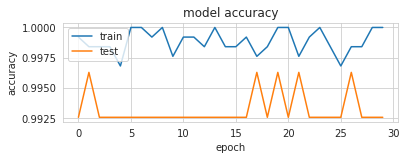

In [36]:
sns.set_style("whitegrid")
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')
plt.show()

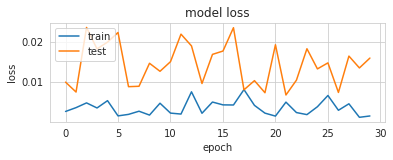

In [37]:
sns.set_style("whitegrid")
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

## 7. Test Result visualization

In [38]:
# Loading file names & their respective target labels into numpy array
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
x_test, y_test,target_labels = load_dataset(test_dir)
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [39]:
y_test = np_utils.to_categorical(y_test,no_of_classes)

In [40]:
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (270, 200, 200, 3)


In [41]:
x_test = x_test.astype('float32')/255

In [42]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))


9/9 [==============================] - 1s 108ms/step - loss: 0.0875 - accuracy: 0.9741
Test: accuracy = 0.974074  ;  loss = 0.087490


## Results of Hot-Rolled Steel Strips Surface Defect Detection

9/9 [==============================] - 1s 114ms/step


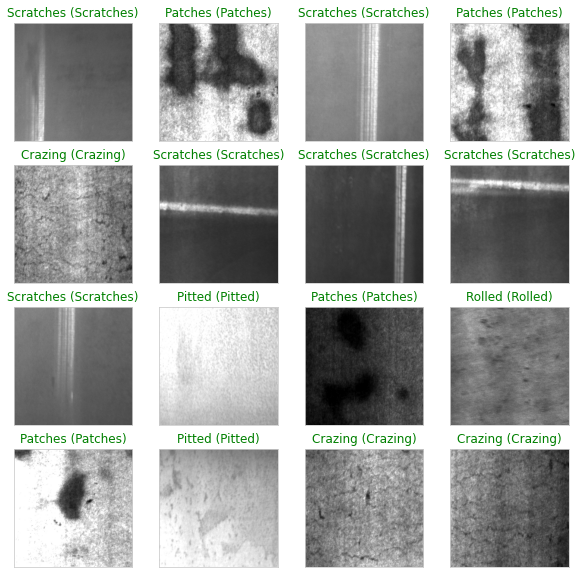

In [24]:
# Plotting Random Sample of test images, their predicted labels, and ground truth
y_pred = model.predict(x_test)
fig = plt.figure(figsize=(10, 10))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))